## 网络分析与信息传播路径研究

### 包括用户影响力识别、社群发现、以及信息扩散路径与时序特征分析。


In [37]:
import pandas as pd
import numpy as np
import networkx as nx
from pathlib import Path
import gc
from community import community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.style = "whitegrid"


### 定义数据目录和事件文件列表

In [38]:
from pathlib import Path

data_dir = Path('output/cleaned')
save_data_dir = Path('output/records')
event_files = [
    "20220518-0524_cleaned.csv.gz",
    "20220623-0701_cleaned.csv.gz",
    "20230301-0305_cleaned.csv.gz",
    "20230518-0524_cleaned.csv.gz"
]

event_names = [
    "Siege_of_Mariupol_20220520_RUS",
    "Battle_of_Sievierodonetsk_20220625_RUS",
    "Bryansk_Oblast_Raid_20230302_RUS/UKR",
    "Battle_of_Bakhmut_20230520_RUS"
]

# Map events to their corresponding files
events_data = list(zip(event_names, event_files))

### 通用函数

In [39]:
def load_event_data(file_path: Path):
    """Load cleaned data for a single event"""
    try:
        df = pd.read_csv(file_path, compression='gzip', encoding='utf-8', engine='python')
        # Ensure time format
        df['tweetcreatedts'] = pd.to_datetime(df['tweetcreatedts'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error loading data: {file_path}, Error: {e}")
        return pd.DataFrame()  # Return an empty DataFrame


def build_retweet_graph(df):
    """Build a retweet network as a directed graph: original_tweet_userid -> userid"""
    df_retweets = df[df['is_retweet'] == True].dropna(subset=['original_tweet_userid', 'userid'])
    G = nx.DiGraph()
    edges = zip(df_retweets['original_tweet_userid'], df_retweets['userid'])
    G.add_edges_from(edges)
    return G


def analyze_network(G):
    """Perform basic network analysis and return a results dictionary"""
    results = {}
    results['num_nodes'] = G.number_of_nodes()
    results['num_edges'] = G.number_of_edges()
    results['density'] = nx.density(G)
    results['avg_degree'] = sum(dict(G.degree()).values()) / results['num_nodes'] if results['num_nodes'] > 0 else 0

    # Calculate in-degree and out-degree
    in_degree = G.in_degree()
    out_degree = G.out_degree()
    in_degree_sorted = sorted(in_degree, key=lambda x: x[1], reverse=True)
    out_degree_sorted = sorted(out_degree, key=lambda x: x[1], reverse=True)
    results['top_in_degree'] = in_degree_sorted[:5]
    results['top_out_degree'] = out_degree_sorted[:5]

    # Calculate PageRank
    try:
        pagerank_values = nx.pagerank(G, alpha=0.85)
        pagerank_sorted = sorted(pagerank_values.items(), key=lambda x: x[1], reverse=True)
        results['top_pagerank'] = pagerank_sorted[:5]
    except Exception as e:
        print(f"Error calculating PageRank: {e}")
        pagerank_values = {}
        results['top_pagerank'] = []

    return results, pagerank_values


def community_detection(G):
    """Perform community detection (Louvain)"""
    try:
        G_undirected = G.to_undirected()
        partition = community_louvain.best_partition(G_undirected, resolution=1.0, random_state=42)
        return partition
    except Exception as e:
        print(f"Error during community detection: {e}")
        return {}


def analyze_communities(partition):
    """Analyze community results and return community distribution information"""
    if not partition:
        return pd.Series(dtype=int), pd.Series(dtype=int)
    comm_series = pd.Series(partition)
    comm_count = comm_series.value_counts()
    return comm_series, comm_count


def visualize_community(G, partition, sample_size=500):
    """Optional community visualization (sampling for large graphs)"""
    if not partition:
        print("No community assignment available for visualization.")
        return

    if G.number_of_nodes() > sample_size:
        # Convert G.nodes() to list to avoid DeprecationWarning
        sampled_nodes = set(random.sample(list(G.nodes()), min(sample_size, G.number_of_nodes())))
        G_sub = G.to_undirected().subgraph(sampled_nodes)
    else:
        G_sub = G.to_undirected()

    if G_sub.number_of_nodes() == 0:
        print("No nodes in the sampled subgraph, skipping visualization.")
        return

    try:
        pos = nx.spring_layout(G_sub, seed=42, k=0.1)
        node_colors = [partition.get(n, 0) for n in G_sub.nodes()]
        plt.figure(figsize=(12, 12))
        nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=50, cmap=plt.cm.Set3)
        nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
        plt.title("Community Partition Visualization (Sampled)")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error visualizing community structure: {e}")


def analyze_diffusion(df, pagerank_values, G, partition, max_nodes_for_bridge=10000):
    """Preliminary analysis of information diffusion, returning top_user, top_bridge_edges, spikes"""
    print("Starting information diffusion analysis...")
    if not pagerank_values:
        print("No PageRank values available for analysis.")
        return None, [], pd.Series()

    # Get the user with the highest PageRank
    try:
        top_user = sorted(pagerank_values.items(), key=lambda x: x[1], reverse=True)[0][0]
        print(f"Top PageRank user: {top_user}")
    except IndexError:
        print("PageRank values are empty, unable to determine top PageRank user.")
        return None, [], pd.Series()

    df_top_user_spread = df[df['original_tweet_userid'] == top_user].copy()

    print(f"Number of retweet records for user {top_user}: {len(df_top_user_spread)}")
    if not df_top_user_spread.empty:
        display(df_top_user_spread.head(5))
    else:
        print("This user has no retweet records.")

    # Sort by time
    df_top_user_spread.sort_values('tweetcreatedts', inplace=True)
    print("Retweet records sorted by time.")

    # Plot retweet time series
    if not df_top_user_spread.empty:
        try:
            plt.figure(figsize=(14, 7))
            df_top_user_spread['tweetcreatedts'].dt.date.value_counts().sort_index().plot(kind='bar', color='skyblue')
            plt.title(f"Retweet Time Distribution for User {top_user}")
            plt.xlabel("Date")
            plt.ylabel("Number of Retweets")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting retweet time series: {e}")
    else:
        print("No retweet time series to plot.")

    # Check for information diffusion spikes
    if not df_top_user_spread.empty:
        retweet_counts = df_top_user_spread['tweetcreatedts'].dt.date.value_counts().sort_index()
        spike_threshold = retweet_counts.mean() + 2 * retweet_counts.std()
        spikes = retweet_counts[retweet_counts > spike_threshold]

        print("\nDates and retweet counts for information diffusion spikes:")
        if not spikes.empty:
            display(spikes)
        else:
            print("No information diffusion spikes detected.")
    else:
        spikes = pd.Series()
        print("\nDates and retweet counts for information diffusion spikes:")
        print(spikes)

    # Identify bridges or bottleneck nodes in information diffusion
    # Only compute edge betweenness centrality for smaller graphs
    if G.number_of_nodes() <= max_nodes_for_bridge:
        try:
            edge_betweenness = nx.edge_betweenness_centrality(G)
            top_bridge_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
            print("\nTop bridge edges in information diffusion (highest betweenness centrality):")
            if top_bridge_edges:
                for edge, betweenness in top_bridge_edges:
                    print(edge, betweenness)
            else:
                print("No bridge edges.")
        except Exception as e:
            print(f"Error calculating bridge edges: {e}")
            top_bridge_edges = []
    else:
        print(f"Graph size too large ({G.number_of_nodes()} nodes), skipping bridge edge calculation.")
        top_bridge_edges = []

    # Visualize bridge edges (only if calculated)
    if top_bridge_edges:
        try:
            bridge_edges = [edge for edge, _ in top_bridge_edges]
            G_bridge = G.edge_subgraph(bridge_edges).copy()

            if len(G_bridge.edges()) > 0:
                pos = nx.spring_layout(G_bridge, seed=42)
                plt.figure(figsize=(12, 12))
                nx.draw_networkx_nodes(G_bridge, pos, node_color='red', node_size=300)
                nx.draw_networkx_edges(G_bridge, pos, edge_color='blue', width=2)
                nx.draw_networkx_labels(G_bridge, pos, font_size=8, font_color='black')
                plt.title("Bridge Edge Visualization in Information Diffusion")
                plt.axis('off')
                plt.show()
            else:
                print("Bridge edge subgraph has no edges, skipping visualization.")
        except Exception as e:
            print(f"Error visualizing bridge edges: {e}")
    else:
        print("No bridge edges to visualize.")

    print("Information diffusion analysis completed.")

    return top_user, top_bridge_edges, spikes


def plot_comparison_metrics(comparison_df, metric, title, ylabel, palette='viridis'):
    """Plot bar chart for comparison metrics"""
    if comparison_df.empty:
        print(f"Comparison DataFrame is empty, cannot plot {title}.")
        return
    plt.figure(figsize=(12, 6))
    sns.barplot(x=comparison_df.index, y=metric, data=comparison_df, palette=palette)
    plt.title(title)
    plt.xlabel("Event")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_scatter_with_regression(comparison_df, x, y, title, xlabel, ylabel):
    """Plot scatter plot with regression line"""
    if comparison_df.empty or comparison_df[x].nunique() < 2 or comparison_df[y].nunique() < 2:
        print(f"Insufficient data to plot scatter plot with regression line: {title}.")
        return
    plt.figure(figsize=(10, 6))
    sns.regplot(x=x, y=y, data=comparison_df, scatter_kws={'s': 100}, line_kws={'color': 'red'})
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def compute_comprehensive_score(comparison_df):
    # Normalize relevant metrics
    comparison_df['largest_community_size_prop'] = comparison_df['largest_community_size'] / comparison_df[
        'largest_community_size'].max() if comparison_df['largest_community_size'].max() > 0 else 0
    comparison_df['spike_ratio_standardized'] = comparison_df['spike_ratio'] / comparison_df['spike_ratio'].max() if \
        comparison_df['spike_ratio'].max() > 0 else 0
    comparison_df['bridge_edge_ratio_standardized'] = comparison_df['bridge_edge_ratio'] / comparison_df[
        'bridge_edge_ratio'].max() if comparison_df['bridge_edge_ratio'].max() > 0 else 0

    # Calculate the comprehensive score
    comparison_df['comprehensive_score'] = (
            0.2 * comparison_df['density'] +
            0.2 * comparison_df['avg_degree'] +
            0.2 * comparison_df['num_communities'] +
            0.2 * comparison_df['largest_community_size_prop'] +
            0.1 * comparison_df['spike_ratio_standardized'] +
            0.1 * comparison_df['bridge_edge_ratio_standardized']
    )

    return comparison_df

### 数据分析


=== Analyzing Event: Siege_of_Mariupol_20220520_RUS ===
Siege_of_Mariupol_20220520_RUS data size: 1140958


,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
0,0,135922295,kuriharan,"Co-founder @pbdlab, develop data privacy cultu...","Tokyo-to, Japan",43512,59613.0,302510,2010-04-22 15:09:22.000000,1526714180597862400,...,0.000000e+00,NaN,0,0.0,NaN,False,0,0.0,NaN,2022-05-18 02:33:09.386131
1,10,1498987592322326539,Mulu999344782,ትግራይ ዓድና ሩባ ሩባ ዓዲ መዓር ፃባ💛❤#StopTigrayGenocide💔...,NaN,1783,2537.0,152872,2022-03-02 11:45:02.000000,1526714183202619394,...,1.494038e+18,AzebAze59444506,0,0.0,NaN,False,0,0.0,NaN,2022-05-18 00:15:06.953969
2,9,17212758,PSUdotcom,"PS4, PSVR and PS5 news, reviews, previews, fea...",Worldwide,1322,46387.0,81564,2008-11-06 15:27:30.000000,1526714182464286720,...,0.000000e+00,NaN,0,0.0,NaN,False,0,0.0,NaN,2022-05-18 00:47:50.422691


Siege_of_Mariupol_20220520_RUS graph - Number of nodes: 242937, Number of edges: 497071
Siege_of_Mariupol_20220520_RUS graph density: 0.000008, Average degree: 4.09
Siege_of_Mariupol_20220520_RUS Network Features:
Number of nodes: 242937
Number of edges: 497071
Top 5 users with highest in-degree: [(1475514588154282000, 267), (3365826074, 265), (49097378, 258), (1053174255926501376, 216), (2916094244, 185)]
Top 5 users with highest out-degree: [(1.2192323776056443e+18, 16044), (19536434.0, 12133), (1891490382.0, 11930), (1.4954805905729615e+18, 11339), (163018653.0, 9112)]
Top 5 users with highest PageRank: [(1475514588154282000, 0.0006399523027642416), (1483850415485890560, 0.00027154547257555024), (3365826074, 0.00024385321014012517), (1203153399266459649, 0.00017247055912775392), (2916094244, 0.00015835826164420767)]
Siege_of_Mariupol_20220520_RUS number of communities: 101
Top 10 largest communities and their user counts:


2     48882
5     28874
4     19118
6     14242
22    11204
10    10816
16     8132
14     6263
15     5896
12     5392
Name: count, dtype: int64

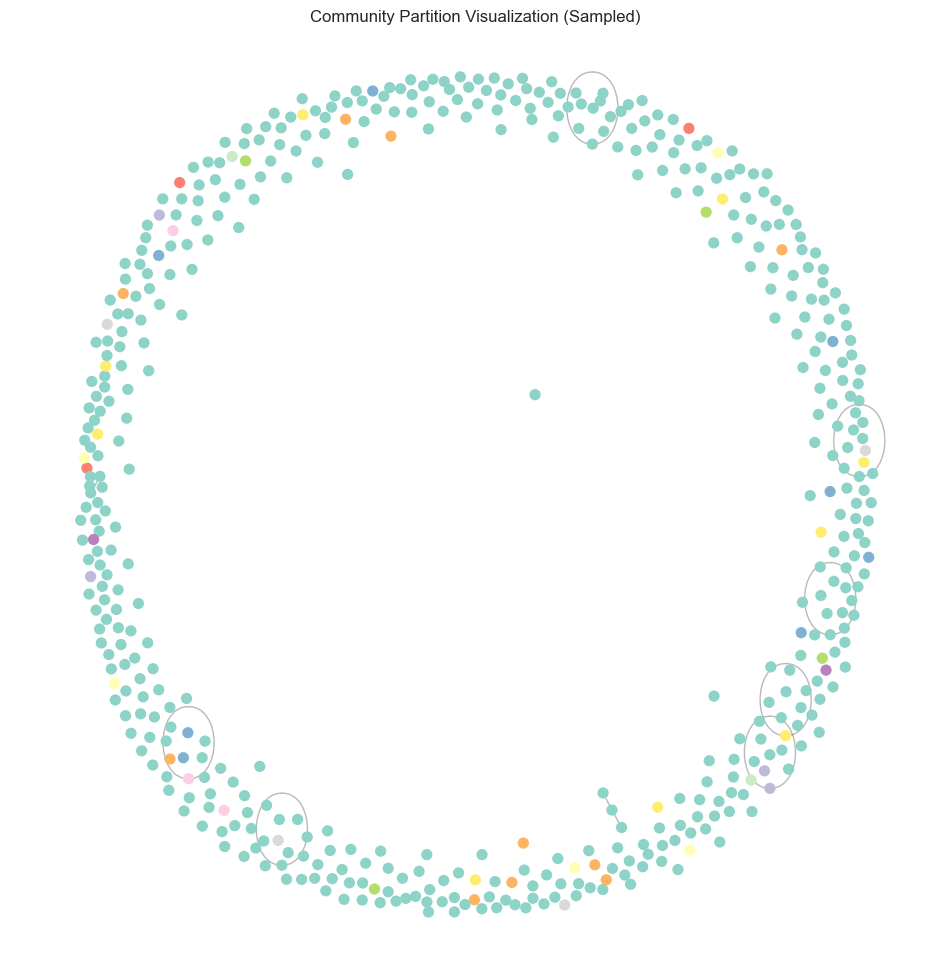

Starting information diffusion analysis...
Top PageRank user: 1475514588154282000
Number of retweet records for user 1475514588154282000: 5


,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
321757,170406,1475514588154282000,HansSars2,Paranormal,NaN,5,182.0,27825,2021-12-27 17:11:57.000000,1527304869303959552,...,1.475515e+18,HansSars2,0,0.0,NaN,True,1526624752986726400,0.0,NaN,2022-05-19 15:23:44.718574
437416,69894,1475514588154282000,HansSars2,Paranormal,NaN,5,185.0,28041,2021-12-27 17:11:57.000000,1527571944152915969,...,1.475515e+18,HansSars2,0,0.0,NaN,True,1526624752986726400,0.0,NaN,2022-05-20 09:24:39.835869
651820,158862,1475514588154282000,HansSars2,Paranormal,NaN,5,187.0,28759,2021-12-27 17:11:57.000000,1528073942119993344,...,1.475515e+18,HansSars2,0,0.0,NaN,True,1520697921179639808,0.0,NaN,2022-05-21 18:27:28.493718
651840,158890,1475514588154282000,HansSars2,Paranormal,NaN,5,187.0,28759,2021-12-27 17:11:57.000000,1528073997681930243,...,1.475515e+18,HansSars2,0,0.0,NaN,False,0,0.0,NaN,2022-05-21 18:27:28.355820
718436,43379,1475514588154282000,HansSars2,Paranormal,NaN,5,189.0,28992,2021-12-27 17:11:57.000000,1528275985216544768,...,1.475515e+18,HansSars2,0,0.0,NaN,True,1526624752986726400,0.0,NaN,2022-05-22 08:13:38.385018


Retweet records sorted by time.


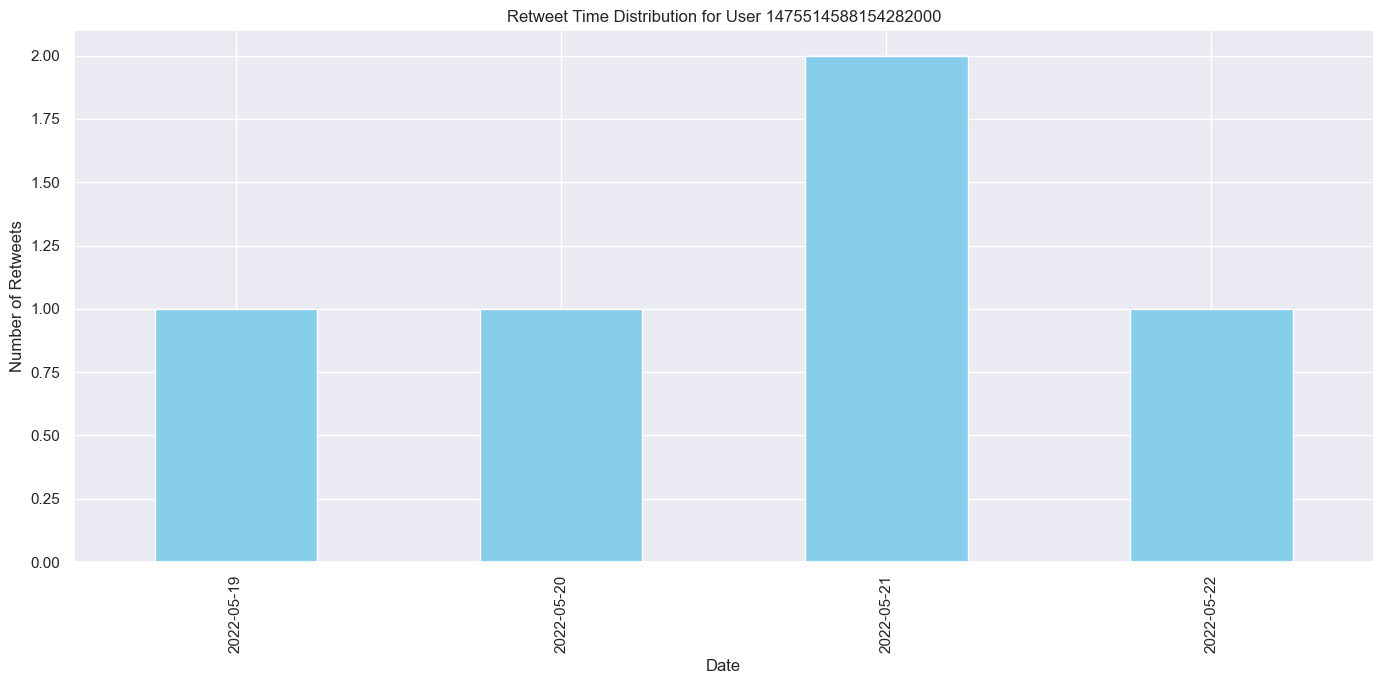


Dates and retweet counts for information diffusion spikes:
No information diffusion spikes detected.
Graph size too large (242937 nodes), skipping bridge edge calculation.
No bridge edges to visualize.
Information diffusion analysis completed.
Saved retweet network graph to: output/records/Siege_of_Mariupol_20220520_RUS_retweet_network.gexf
Saved community assignments to: output/records/Siege_of_Mariupol_20220520_RUS_communities.csv
No information diffusion spikes to save.

=== Analyzing Event: Battle_of_Sievierodonetsk_20220625_RUS ===
Battle_of_Sievierodonetsk_20220625_RUS data size: 1257862


,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
0,12,125612663,Ashok2103,"Conscious about society around. Explore life, ...","Bangalore, India",2419,284.0,10550,2010-03-23 09:55:38.000000,1539760145114116096,...,0.0,NaN,0,0.0,NaN,False,0,0.0,NaN,2022-06-23 04:34:57.764793
1,8,272502906,GainMoneyFaster,𝙈𝙤𝙣𝙚𝙮 𝘾𝙤𝙖𝙘𝙝 showing you best Clever Passive In...,Bilbao,5658,5348.0,43146,2011-03-26 17:01:39.000000,1539760144489127936,...,0.0,NaN,0,0.0,NaN,False,0,0.0,NaN,2022-06-23 00:21:05.114492
2,6,1244796162751655936,RussianLadies1,https://t.co/3xq2MQahdt is one of the largest ...,Russia,880,412.0,493,2020-03-31 01:19:00.000000,1539760143952269312,...,0.0,NaN,0,0.0,NaN,False,0,0.0,NaN,2022-06-23 04:34:57.795632


Battle_of_Sievierodonetsk_20220625_RUS graph - Number of nodes: 267054, Number of edges: 545226
Battle_of_Sievierodonetsk_20220625_RUS graph density: 0.000008, Average degree: 4.08
Battle_of_Sievierodonetsk_20220625_RUS Network Features:
Number of nodes: 267054
Number of edges: 545226
Top 5 users with highest in-degree: [(281826197, 229), (1053174255926501376, 219), (1266145259718955010, 216), (49097378, 192), (1495855082734297095, 190)]
Top 5 users with highest out-degree: [(1.505481949854503e+18, 20285), (1891490382.0, 14608), (1.2192323776056443e+18, 12804), (2749315621.0, 11839), (163018653.0, 11226)]
Top 5 users with highest PageRank: [(1536331953632423936, 0.00032627460725122786), (76387272, 0.00016314328625955063), (1483850415485890560, 0.00015344478108530432), (281826197, 0.00015263498289762501), (1203153399266459649, 0.00014805942979868923)]
Battle_of_Sievierodonetsk_20220625_RUS number of communities: 114
Top 10 largest communities and their user counts:


4     37824
15    31706
6     21507
0     16869
3     15271
1     14421
21    10292
8      8345
11     7122
43     6581
Name: count, dtype: int64

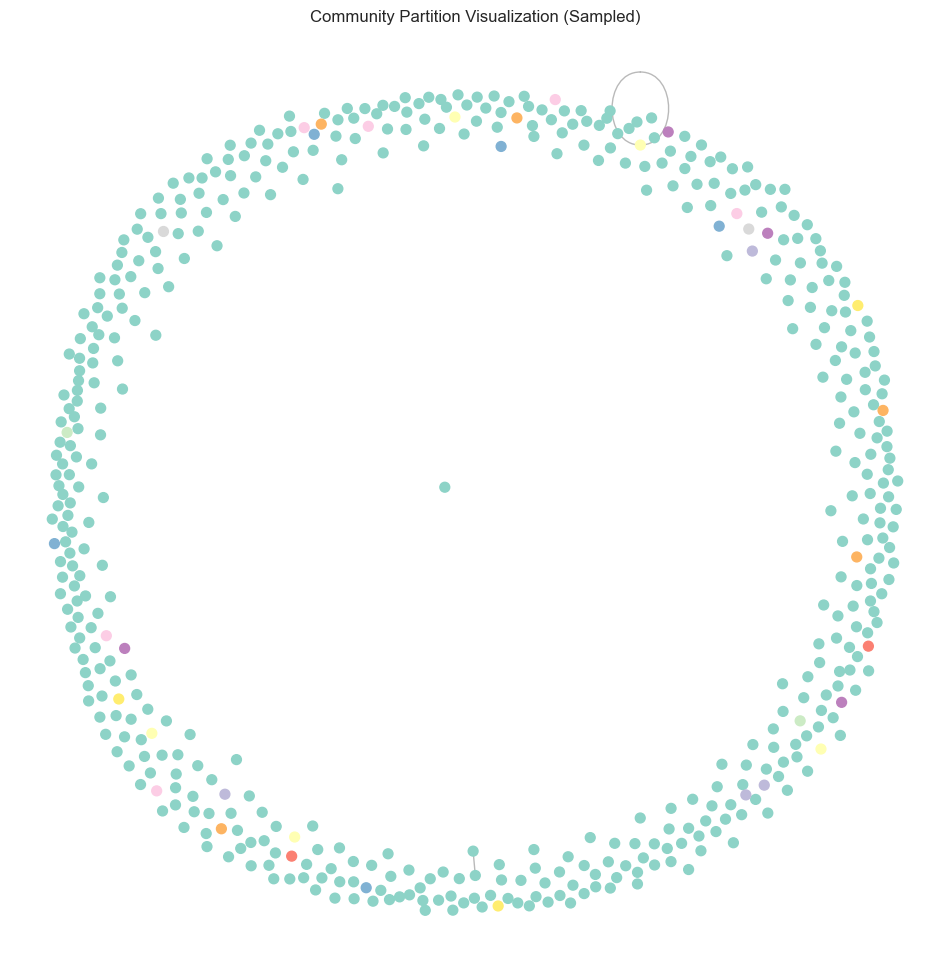

Starting information diffusion analysis...
Top PageRank user: 1536331953632423936
Number of retweet records for user 1536331953632423936: 0
This user has no retweet records.
Retweet records sorted by time.
No retweet time series to plot.

Dates and retweet counts for information diffusion spikes:
Series([], dtype: object)
Graph size too large (267054 nodes), skipping bridge edge calculation.
No bridge edges to visualize.
Information diffusion analysis completed.
Saved retweet network graph to: output/records/Battle_of_Sievierodonetsk_20220625_RUS_retweet_network.gexf
Saved community assignments to: output/records/Battle_of_Sievierodonetsk_20220625_RUS_communities.csv
No information diffusion spikes to save.

=== Analyzing Event: Bryansk_Oblast_Raid_20230302_RUS/UKR ===
Bryansk_Oblast_Raid_20230302_RUS/UKR data size: 434861


,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
0,157956,3951058893,danlee863,"⚽, #TeamCanada🇨🇦 ,🐱,The Truman Show, Inconsist...",Worldwide 🌎,1835,85,18389,2015-10-14 00:27:26,1630719497123373058,...,382662522,CFOperations,0,0.000000e+00,NaN,False,0,0.0,NaN,2023-03-01 00:48:02.340921
1,157961,1620831279309787136,RobertB37684928,NaN,NaN,66,14,242,2023-02-01 17:09:00,1630719499946299399,...,0,NaN,1630519942331219968,1.471509e+18,WhereisRussia,False,0,0.0,NaN,2023-03-01 09:16:08.956689
2,157957,1629112447390068739,AmaliaCSantos2,NaN,NaN,16,2,4,2023-02-24 13:34:54,1630719497471655936,...,0,NaN,0,0.000000e+00,NaN,False,0,0.0,NaN,2023-03-01 00:50:02.925157


Bryansk_Oblast_Raid_20230302_RUS/UKR graph - Number of nodes: 119158, Number of edges: 223192
Bryansk_Oblast_Raid_20230302_RUS/UKR graph density: 0.000016, Average degree: 3.75
Bryansk_Oblast_Raid_20230302_RUS/UKR Network Features:
Number of nodes: 119158
Number of edges: 223192
Top 5 users with highest in-degree: [(596502612, 269), (1688880763, 134), (1239828992137576450, 100), (1053174255926501376, 88), (25877022, 87)]
Top 5 users with highest out-degree: [(2758100418, 6362), (1519380400749035520, 5277), (132512167, 4318), (1174451010, 3819), (1495480590572961792, 3231)]
Top 5 users with highest PageRank: [(1572825337091825664, 0.0006404016632904383), (596502612, 0.0005852597799725767), (1409469669115940867, 0.00023933737719370412), (1216550422191587328, 0.00020082317562727185), (1265070105244958727, 0.00013589061722435976)]
Bryansk_Oblast_Raid_20230302_RUS/UKR number of communities: 96
Top 10 largest communities and their user counts:


4     16783
5     12295
8     11389
3      9364
9      8120
2      6535
73     3486
6      3275
29     3215
21     3068
Name: count, dtype: int64

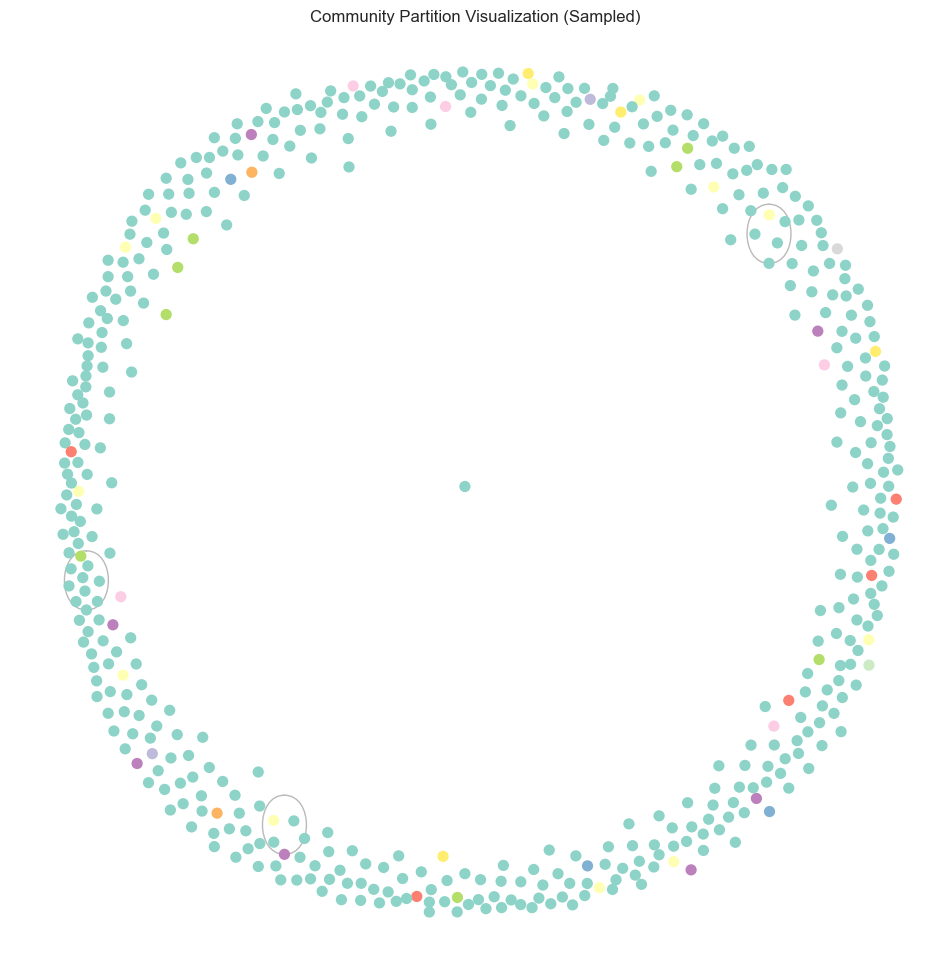

Starting information diffusion analysis...
Top PageRank user: 1572825337091825664
Number of retweet records for user 1572825337091825664: 1


,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
140599,267782,1572825337091825664,DivineOwali7_,"Interesting facts and stories on science, art,...","Cross River, Nigeria",2092,2163,35659,2022-09-22 05:49:32,1631314385355386882,...,1572825337091825664,DivineOwali7_,0,0.0,NaN,False,0,0.0,NaN,2023-03-02 15:33:18.638280


Retweet records sorted by time.


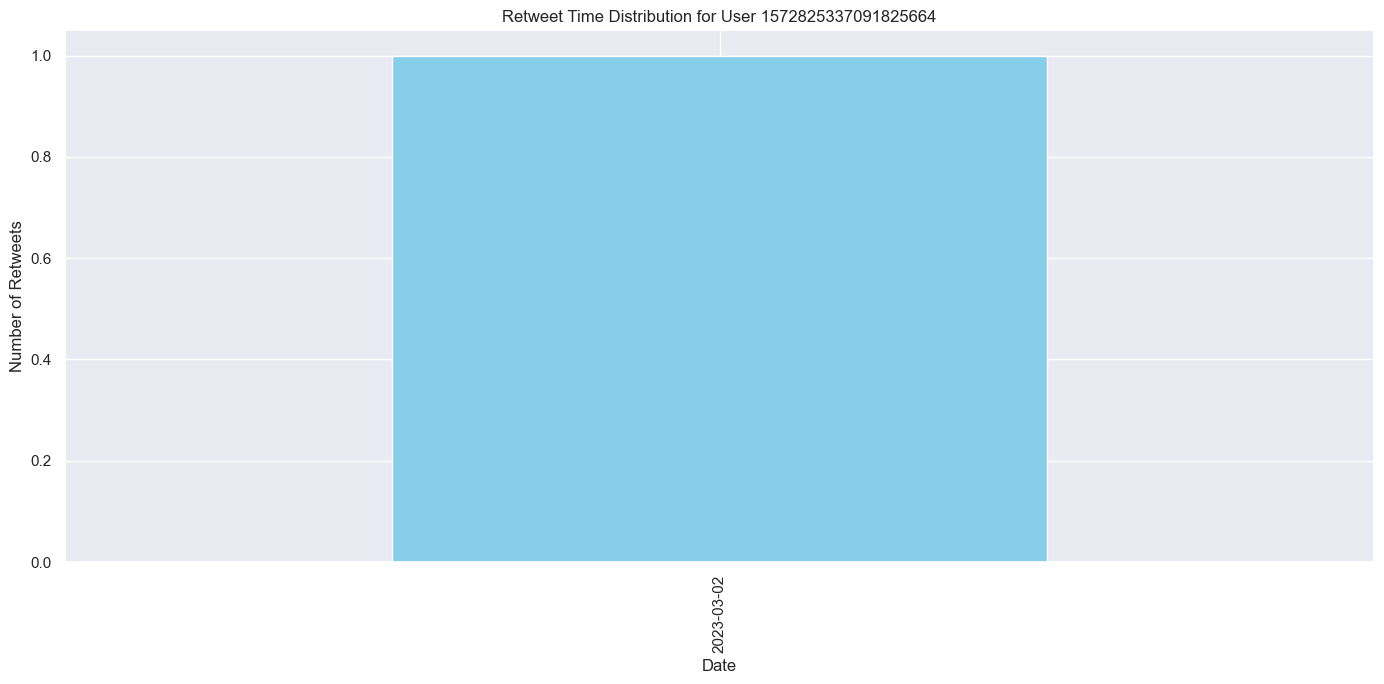


Dates and retweet counts for information diffusion spikes:
No information diffusion spikes detected.
Graph size too large (119158 nodes), skipping bridge edge calculation.
No bridge edges to visualize.
Information diffusion analysis completed.
Error saving retweet network graph: [Errno 2] No such file or directory: 'output/records/Bryansk_Oblast_Raid_20230302_RUS/UKR_retweet_network.gexf'
Error saving community assignments: Cannot save file into a non-existent directory: 'output/records/Bryansk_Oblast_Raid_20230302_RUS'
No information diffusion spikes to save.

=== Analyzing Event: Battle_of_Bakhmut_20230520_RUS ===
Battle_of_Bakhmut_20230520_RUS data size: 91987


,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
0,3592,1282574131599486977,ripetvnews,Latest and Breaking News and Updates from all ...,NaN,4,207,4861,2020-07-13 07:16:00,1658985758378856449,...,0.0,NaN,0,0.0,NaN,False,0,0.0,NaN,2023-05-18 03:24:44.509254
1,3599,1612668913216618496,badry_98,يعتمد نجاحك في الحياة عليك أكثر من أي عوامل خا...,Libya,179,33,7298,2023-01-10 04:34:08,1658985948820955138,...,0.0,NaN,0,0.0,NaN,False,0,0.0,NaN,2023-05-18 03:24:44.463920
2,3602,1578037094785507329,Hkjhgc2,NaN,NaN,18,82,66139,2022-10-06 14:59:21,1658985984002781184,...,0.0,NaN,0,0.0,NaN,False,0,0.0,NaN,2023-05-18 03:24:44.441208


Battle_of_Bakhmut_20230520_RUS graph - Number of nodes: 27516, Number of edges: 39612
Battle_of_Bakhmut_20230520_RUS graph density: 0.000052, Average degree: 2.88
Battle_of_Bakhmut_20230520_RUS Network Features:
Number of nodes: 27516
Number of edges: 39612
Top 5 users with highest in-degree: [(1502693520544436226, 42), (1142456914212773889, 33), (2165303925, 28), (2828664616, 26), (1424313100316995588, 24)]
Top 5 users with highest out-degree: [(71298686.0, 2020), (9.348106744500593e+17, 1296), (14106476.0, 1184), (2528195210.0, 1133), (1.510780961281409e+18, 1118)]
Top 5 users with highest PageRank: [(1502693520544436226, 0.00039292778031111726), (1405264295374503942, 0.00021822328116790824), (137777900, 0.00017287093636556732), (317650496, 0.00017128455615355383), (2828664616, 0.00016975130474434035)]
Battle_of_Bakhmut_20230520_RUS number of communities: 63
Top 10 largest communities and their user counts:


7     3526
2     2571
3     2054
15    1672
26    1588
9     1369
16    1285
50     930
8      739
10     729
Name: count, dtype: int64

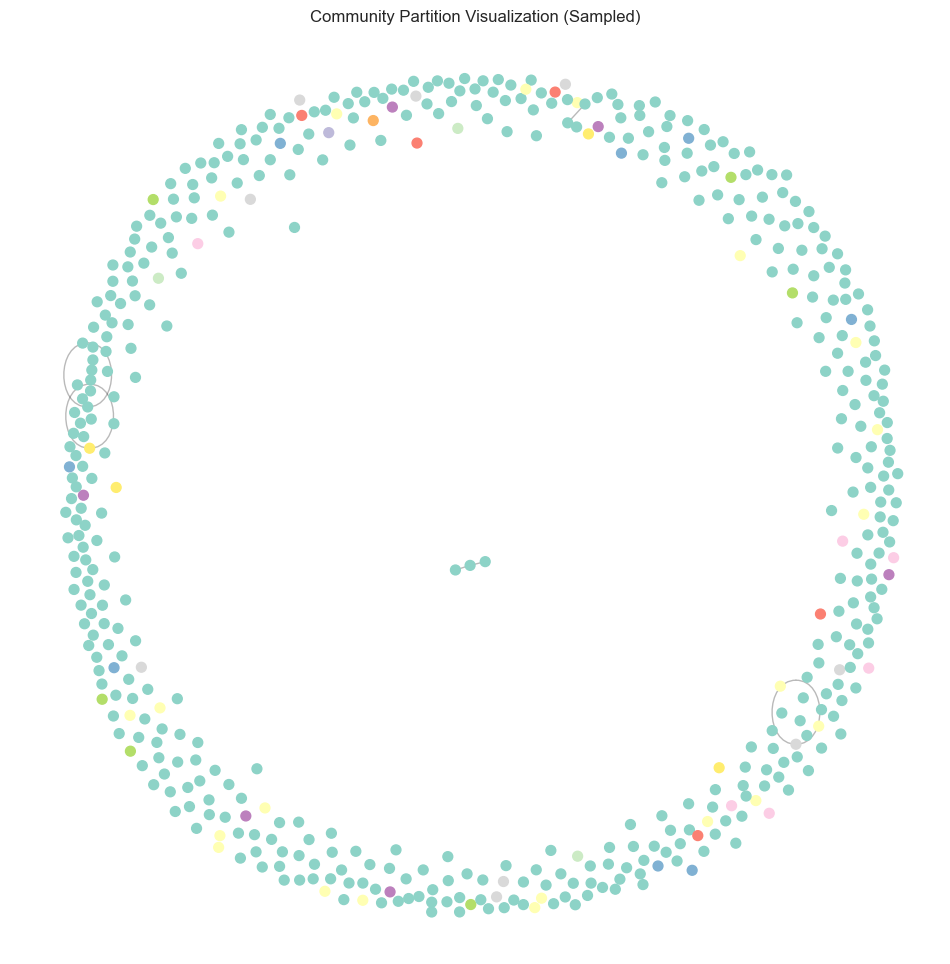

Starting information diffusion analysis...
Top PageRank user: 1502693520544436226
Number of retweet records for user 1502693520544436226: 0
This user has no retweet records.
Retweet records sorted by time.
No retweet time series to plot.

Dates and retweet counts for information diffusion spikes:
Series([], dtype: object)
Graph size too large (27516 nodes), skipping bridge edge calculation.
No bridge edges to visualize.
Information diffusion analysis completed.
Saved retweet network graph to: output/records/Battle_of_Bakhmut_20230520_RUS_retweet_network.gexf
Saved community assignments to: output/records/Battle_of_Bakhmut_20230520_RUS_communities.csv
No information diffusion spikes to save.


In [40]:
all_results = {}

for event_name, file_name in events_data:
    print(f"\n=== Analyzing Event: {event_name} ===")
    file_path = data_dir / file_name
    if not file_path.exists():
        print(f"File {file_name} does not exist, skipping this event.")
        all_results[event_name] = {
            "num_nodes": 0,
            "num_edges": 0,
            "density": 0,
            "avg_degree": 0,
            "top_in_degree_users": [],
            "top_out_degree_users": [],
            "top_pagerank_users": [],
            "num_communities": 0,
            "largest_community_size": 0,
            "largest_community_prop": 0,
            "top_pagerank_user": None,
            "top_user_spread_count": 0,
            "spike_ratio": 0,
            "bridge_edge_ratio": 0,
            "spikes": pd.Series()
        }
        continue

    # 1. Load data
    df = load_event_data(file_path)
    if df.empty:
        print(f"{event_name} data is empty, skipping this event.")
        all_results[event_name] = {
            "num_nodes": 0,
            "num_edges": 0,
            "density": 0,
            "avg_degree": 0,
            "top_in_degree_users": [],
            "top_out_degree_users": [],
            "top_pagerank_users": [],
            "num_communities": 0,
            "largest_community_size": 0,
            "largest_community_prop": 0,
            "top_pagerank_user": None,
            "top_user_spread_count": 0,
            "spike_ratio": 0,
            "bridge_edge_ratio": 0,
            "spikes": pd.Series()
        }
        continue

    print(f"{event_name} data size: {len(df)}")
    display(df.head(3))

    # 2. Build retweet network
    G = build_retweet_graph(df)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    avg_degree = sum(dict(G.degree()).values()) / num_nodes if num_nodes > 0 else 0

    print(f"{event_name} graph - Number of nodes: {num_nodes}, Number of edges: {num_edges}")
    print(f"{event_name} graph density: {density:.6f}, Average degree: {avg_degree:.2f}")

    if num_nodes == 0:
        print(f"{event_name} has no retweet relationships, skipping further analysis.")
        all_results[event_name] = {
            "num_nodes": 0,
            "num_edges": 0,
            "density": density,
            "avg_degree": avg_degree,
            "top_in_degree_users": [],
            "top_out_degree_users": [],
            "top_pagerank_users": [],
            "num_communities": 0,
            "largest_community_size": 0,
            "largest_community_prop": 0,
            "top_pagerank_user": None,
            "top_user_spread_count": 0,
            "spike_ratio": 0,
            "bridge_edge_ratio": 0,
            "spikes": pd.Series()
        }
        # Clear memory
        del df, G
        gc.collect()
        continue

    # 3. Network analysis
    network_results, pagerank_values = analyze_network(G)
    print(f"{event_name} Network Features:")
    print("Number of nodes:", network_results['num_nodes'])
    print("Number of edges:", network_results['num_edges'])
    print("Top 5 users with highest in-degree:", network_results['top_in_degree'])
    print("Top 5 users with highest out-degree:", network_results['top_out_degree'])
    print("Top 5 users with highest PageRank:", network_results['top_pagerank'])

    # 4. Community detection
    partition = community_detection(G)
    comm_series, comm_count = analyze_communities(partition)
    if not comm_count.empty:
        print(f"{event_name} number of communities:", comm_count.nunique())
        print("Top 10 largest communities and their user counts:")
        display(comm_count.head(10))
    else:
        print(f"{event_name} has no community assignments.")

    # 5. Visualize community structure
    visualize_community(G, partition, sample_size=500)

    # 6. Information diffusion analysis
    # Set a reasonable threshold, e.g., 10,000 nodes
    top_user, top_bridge_edges, spikes = analyze_diffusion(df, pagerank_values, G, partition,
                                                           max_nodes_for_bridge=10000)
    top_user_spread_count = len(df[df['original_tweet_userid'] == top_user]) if top_user else 0
    total_spreads = len(df[df['is_retweet'] == True])
    spike_ratio = spikes.sum() / total_spreads if total_spreads > 0 else 0
    bridge_edge_ratio = len(top_bridge_edges) / num_edges if num_edges > 0 else 0

    # 7. Analyze community size distribution
    if not comm_count.empty:
        largest_community_size = comm_count.iloc[0]
        largest_community_prop = largest_community_size / comm_count.sum() if comm_count.sum() > 0 else 0
    else:
        largest_community_size = 0
        largest_community_prop = 0

    # 8. Store results
    all_results[event_name] = {
        "num_nodes": network_results['num_nodes'],
        "num_edges": network_results['num_edges'],
        "density": network_results['density'],
        "avg_degree": network_results['avg_degree'],
        "top_in_degree_users": network_results['top_in_degree'],
        "top_out_degree_users": network_results['top_out_degree'],
        "top_pagerank_users": network_results['top_pagerank'],
        "num_communities": comm_count.nunique() if not comm_count.empty else 0,
        "largest_community_size": largest_community_size,
        "largest_community_prop": largest_community_prop,
        "top_pagerank_user": top_user,
        "top_user_spread_count": top_user_spread_count,
        "spike_ratio": spike_ratio,
        "bridge_edge_ratio": bridge_edge_ratio,
        "spikes": spikes
    }

    # 9. Save analysis results
    # Save retweet network graph
    try:
        G_output_path = save_data_dir / f"{event_name}_retweet_network.gexf"
        nx.write_gexf(G, G_output_path)
        print(f"Saved retweet network graph to: {G_output_path}")
    except Exception as e:
        print(f"Error saving retweet network graph: {e}")

    # Save community assignments
    try:
        comm_output_path = save_data_dir / f"{event_name}_communities.csv"
        comm_series.to_csv(comm_output_path, header=['community'])
        print(f"Saved community assignments to: {comm_output_path}")
    except Exception as e:
        print(f"Error saving community assignments: {e}")

    # Save information diffusion spikes
    if top_user and not spikes.empty:
        try:
            spikes_output_path = save_data_dir / f"{event_name}_spikes.csv"
            spikes.to_csv(spikes_output_path, header=['retweet_count'])
            print(f"Saved information diffusion spikes to: {spikes_output_path}")
        except Exception as e:
            print(f"Error saving information diffusion spikes: {e}")
    else:
        print("No information diffusion spikes to save.")

    # Clear memory
    del df, G, partition, comm_series, comm_count, top_bridge_edges, spikes
    gc.collect()

### 4. 综合比较四个事件的网络特征

In [48]:
# Create a DataFrame to store key metrics for all events
comparison_df = pd.DataFrame(columns=[
    "num_nodes",
    "num_edges",
    "density",
    "avg_degree",
    "num_communities",
    "largest_community_size",
    "largest_community_prop",
    "top_pagerank_user",
    "top_user_spread_count",
    "spike_ratio",
    "bridge_edge_ratio"
])

for event, metrics in all_results.items():
    comparison_df.loc[event] = [
        metrics["num_nodes"],
        metrics["num_edges"],
        metrics["density"],
        metrics["avg_degree"],
        metrics["num_communities"],
        metrics["largest_community_size"],
        metrics["largest_community_prop"],
        metrics["top_pagerank_user"],
        metrics["top_user_spread_count"],
        metrics["spike_ratio"],
        metrics["bridge_edge_ratio"]
    ]

print("\n=== Comparison of Network Features for four Events ===")
print(comparison_df)
display(comparison_df)


=== Comparison of Network Features for four Events ===
                                        num_nodes  num_edges   density  \
Siege_of_Mariupol_20220520_RUS           242937.0   497071.0  0.000008   
Battle_of_Sievierodonetsk_20220625_RUS   267054.0   545226.0  0.000008   
Bryansk_Oblast_Raid_20230302_RUS/UKR     119158.0   223192.0  0.000016   
Battle_of_Bakhmut_20230520_RUS            27516.0    39612.0  0.000052   

                                        avg_degree  num_communities  \
Siege_of_Mariupol_20220520_RUS            4.092180            101.0   
Battle_of_Sievierodonetsk_20220625_RUS    4.083264            114.0   
Bryansk_Oblast_Raid_20230302_RUS/UKR      3.746152             96.0   
Battle_of_Bakhmut_20230520_RUS            2.879198             63.0   

                                        largest_community_size  \
Siege_of_Mariupol_20220520_RUS                         48882.0   
Battle_of_Sievierodonetsk_20220625_RUS                 37824.0   
Bryansk_Oblast_Raid

,num_nodes,num_edges,density,avg_degree,num_communities,largest_community_size,largest_community_prop,top_pagerank_user,top_user_spread_count,spike_ratio,bridge_edge_ratio
Siege_of_Mariupol_20220520_RUS,242937.0,497071.0,0.000008,4.092180,101.0,48882.0,0.201213,1.475515e+18,5.0,0.0,0.0
Battle_of_Sievierodonetsk_20220625_RUS,267054.0,545226.0,0.000008,4.083264,114.0,37824.0,0.141634,1.536332e+18,0.0,0.0,0.0
Bryansk_Oblast_Raid_20230302_RUS/UKR,119158.0,223192.0,0.000016,3.746152,96.0,16783.0,0.140847,1.572825e+18,1.0,0.0,0.0
Battle_of_Bakhmut_20230520_RUS,27516.0,39612.0,0.000052,2.879198,63.0,3526.0,0.128144,1.502694e+18,0.0,0.0,0.0


### 5. 可视化比较指标

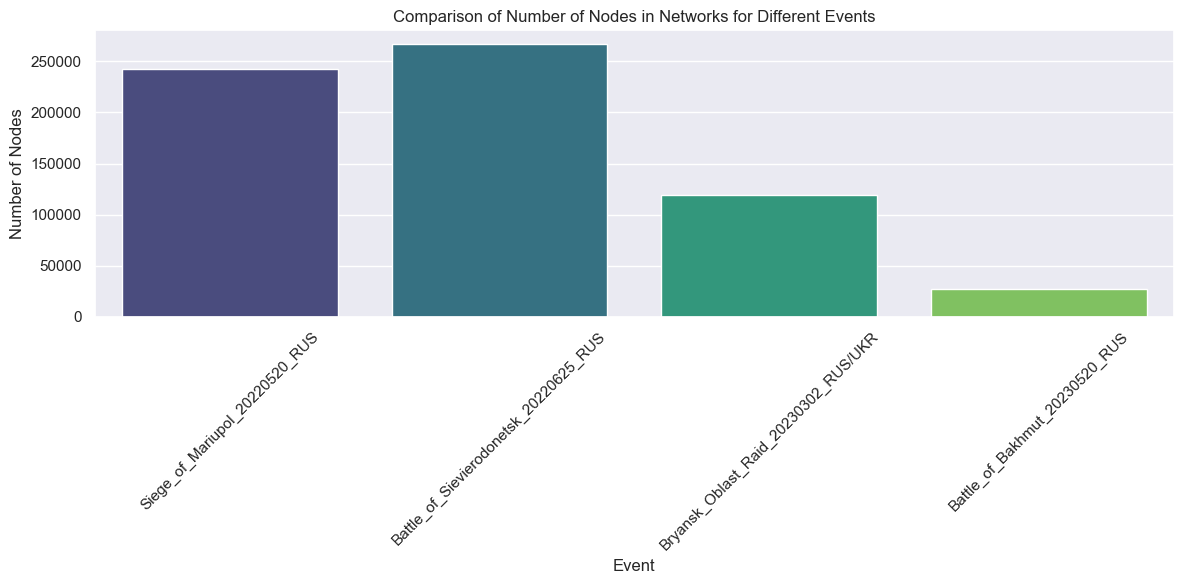

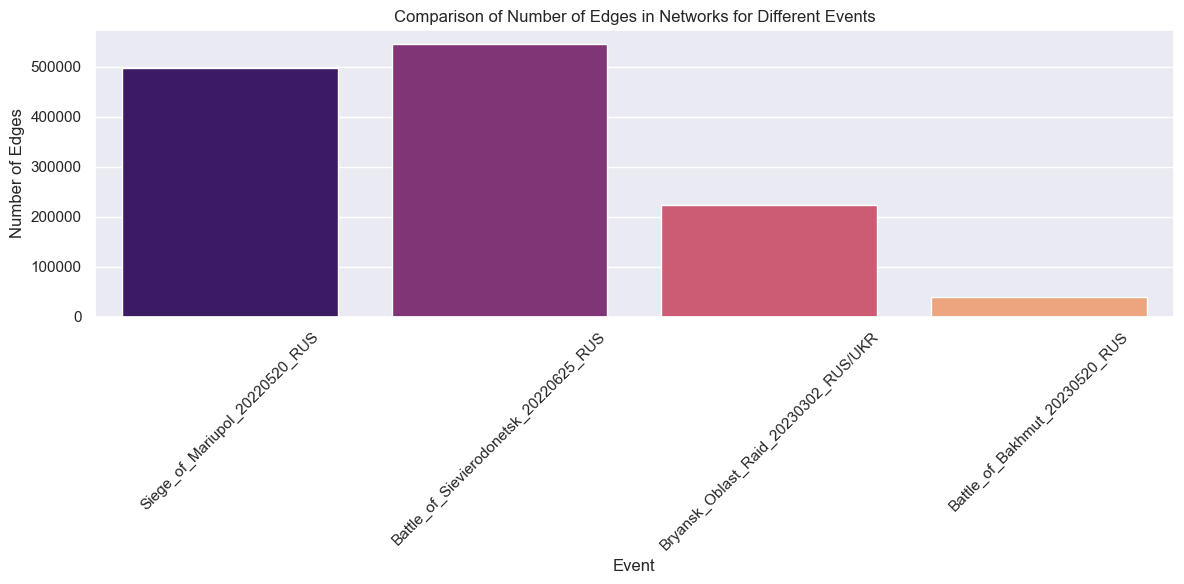

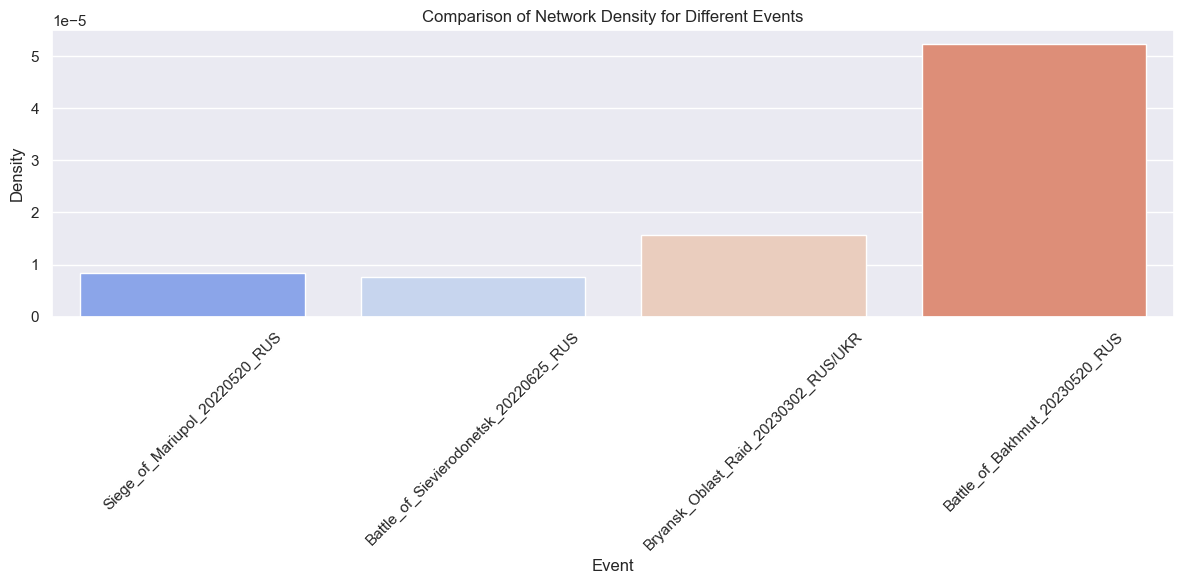

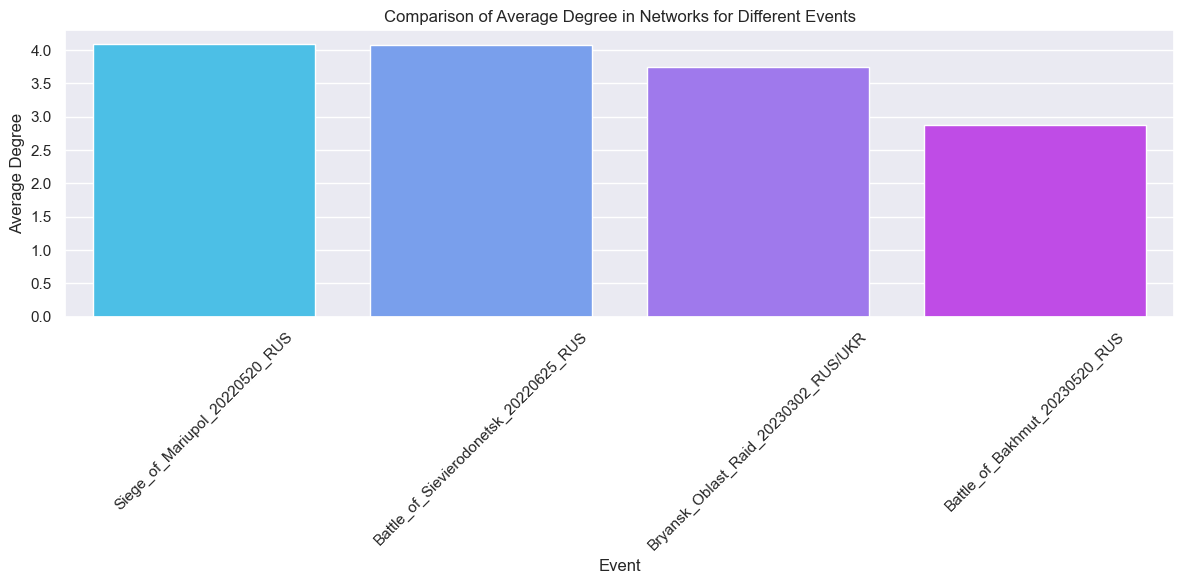

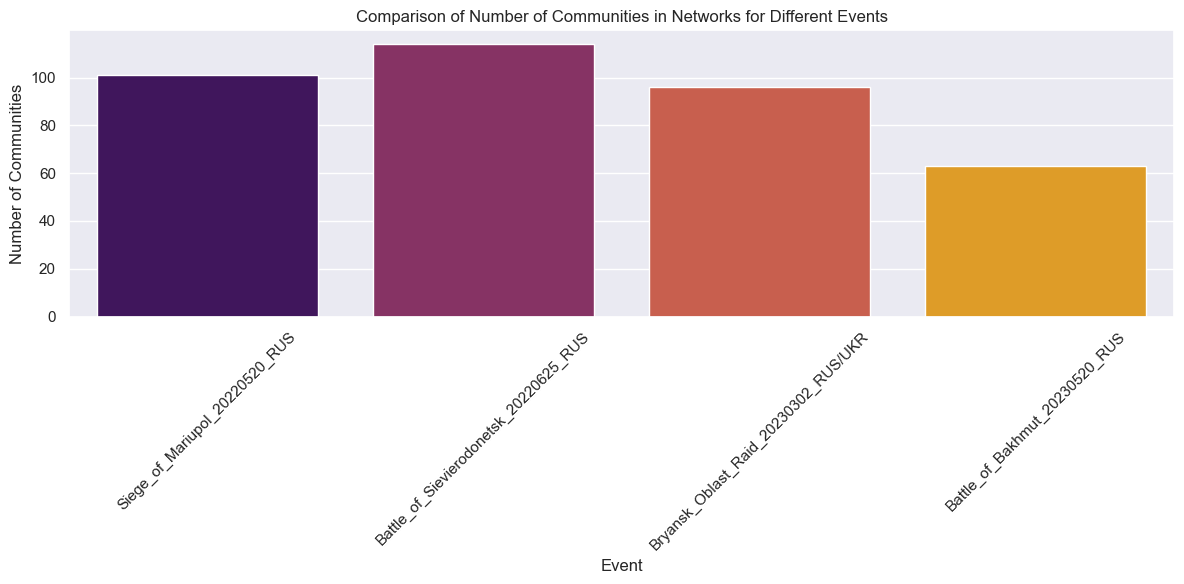

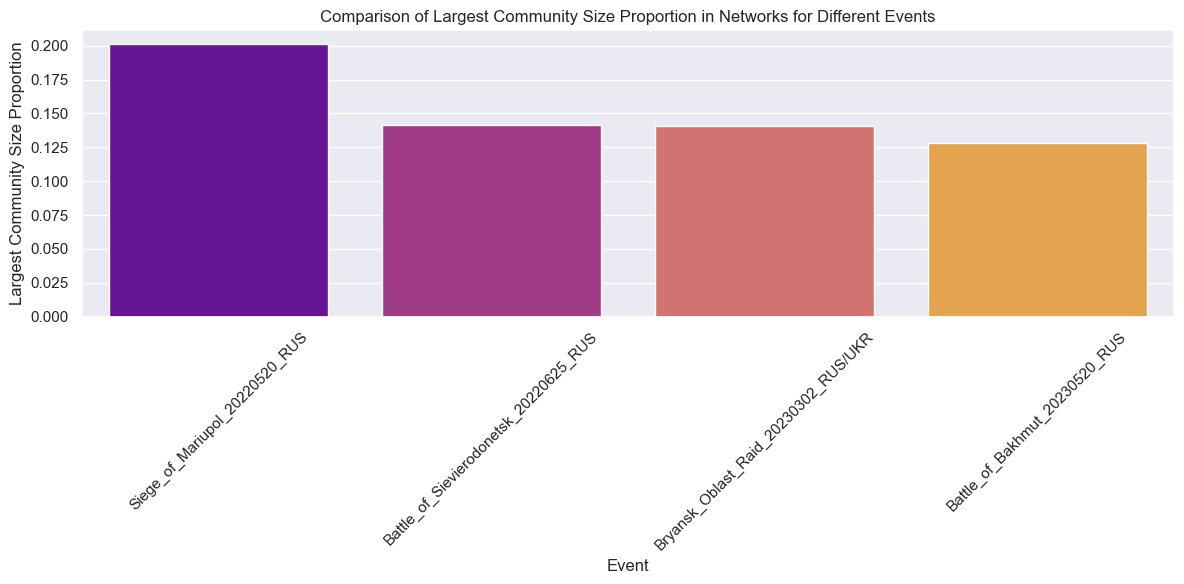

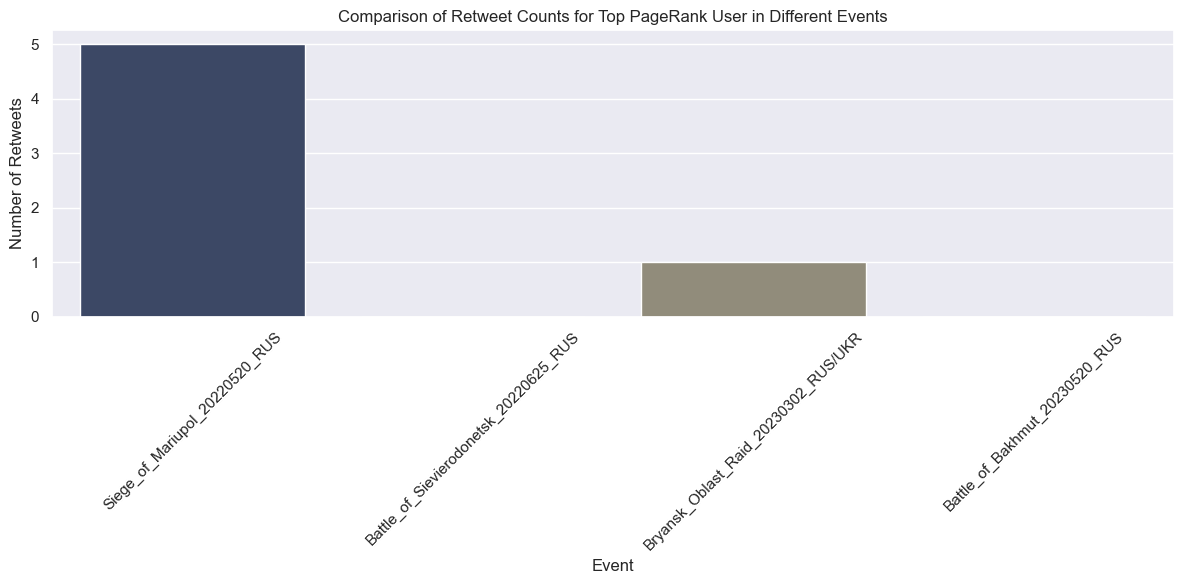

In [46]:
# Comparison of number of nodes
plot_comparison_metrics(comparison_df, 'num_nodes', "Comparison of Number of Nodes in Networks for Different Events",
                        "Number of Nodes", palette='viridis')

# Comparison of number of edges
plot_comparison_metrics(comparison_df, 'num_edges', "Comparison of Number of Edges in Networks for Different Events",
                        "Number of Edges", palette='magma')

# Comparison of network density
plot_comparison_metrics(comparison_df, 'density', "Comparison of Network Density for Different Events", "Density",
                        palette='coolwarm')

# Comparison of average degree
plot_comparison_metrics(comparison_df, 'avg_degree', "Comparison of Average Degree in Networks for Different Events",
                        "Average Degree", palette='cool')

# Comparison of number of communities
plot_comparison_metrics(comparison_df, 'num_communities',
                        "Comparison of Number of Communities in Networks for Different Events", "Number of Communities",
                        palette='inferno')

# Comparison of largest community size proportion
plot_comparison_metrics(comparison_df, 'largest_community_prop',
                        "Comparison of Largest Community Size Proportion in Networks for Different Events",
                        "Largest Community Size Proportion", palette='plasma')

# Comparison of retweet counts for the most influential user
plot_comparison_metrics(comparison_df, 'top_user_spread_count',
                        "Comparison of Retweet Counts for Top PageRank User in Different Events", "Number of Retweets",
                        palette='cividis')

### 6. 散点图与回归分析

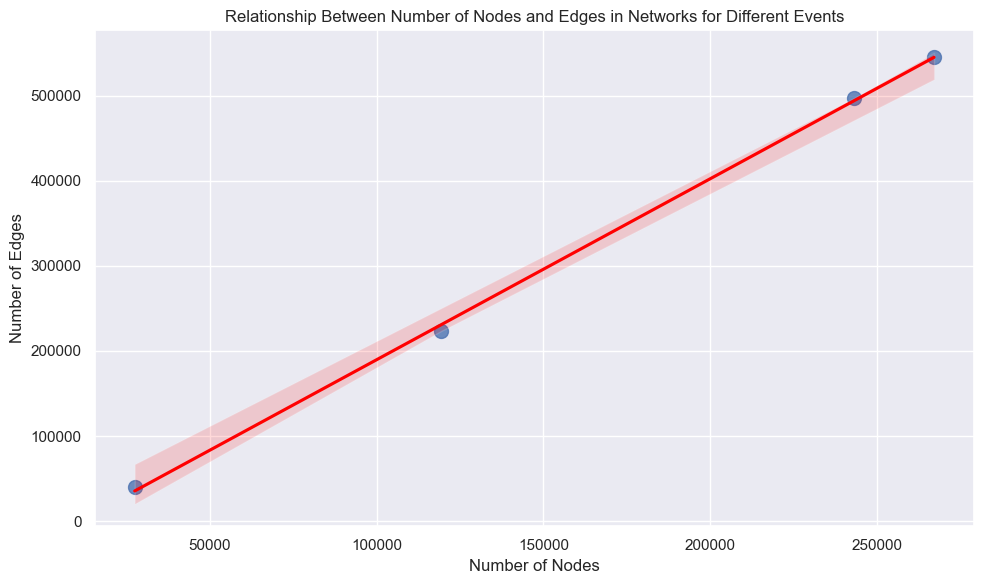

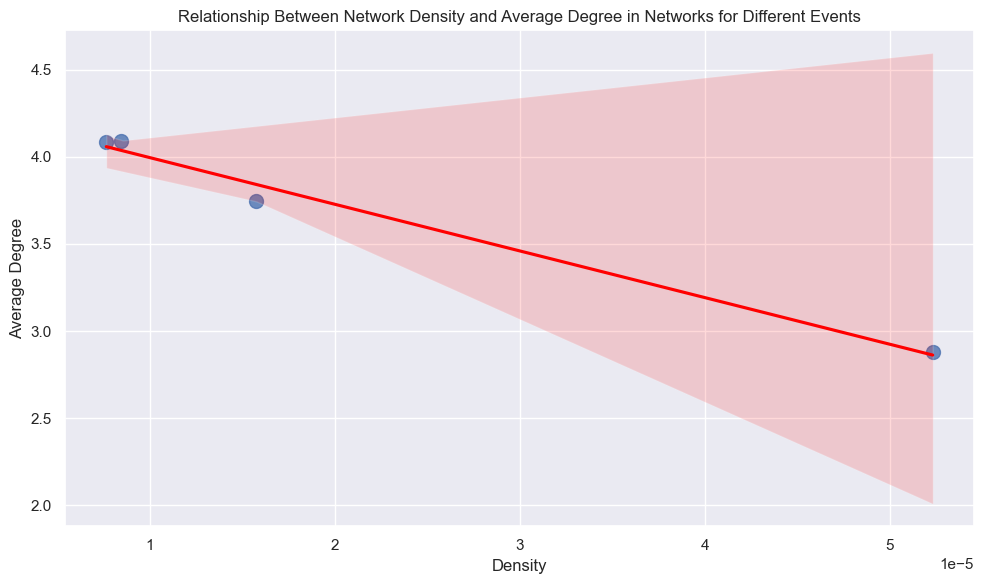

In [47]:
# Relationship between number of nodes and number of edges
plot_scatter_with_regression(comparison_df, 'num_nodes', 'num_edges',
                             "Relationship Between Number of Nodes and Edges in Networks for Different Events",
                             "Number of Nodes", "Number of Edges")

# Relationship between network density and average degree
plot_scatter_with_regression(comparison_df, 'density', 'avg_degree',
                             "Relationship Between Network Density and Average Degree in Networks for Different Events",
                             "Density", "Average Degree")

### 7. 综合评分


=== Comparison of Comprehensive Scores for Six Events ===


,comprehensive_score
Battle_of_Sievierodonetsk_20220625_RUS,23.771411
Siege_of_Mariupol_20220520_RUS,21.218438
Bryansk_Oblast_Raid_20230302_RUS/UKR,20.017901
Battle_of_Bakhmut_20230520_RUS,13.190277


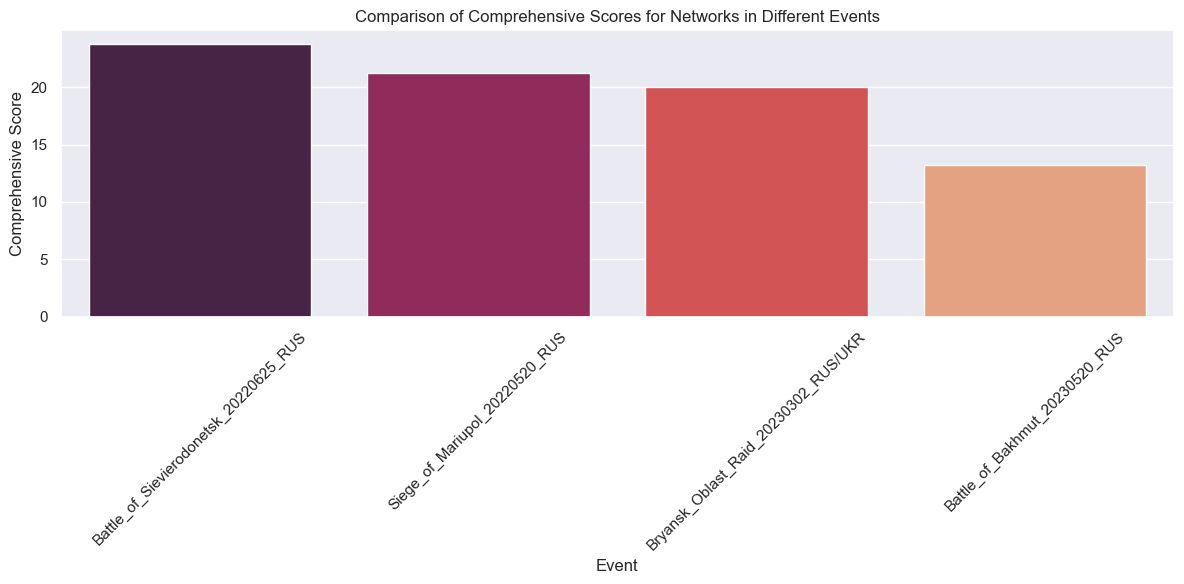

In [44]:
comparison_df = compute_comprehensive_score(comparison_df)

# Sorting
comparison_df_sorted = comparison_df.sort_values(by='comprehensive_score', ascending=False)
print("\n=== Comparison of Comprehensive Scores for Six Events ===")
display(comparison_df_sorted[['comprehensive_score']])

# Visualization of comprehensive scores
plt.figure(figsize=(12, 6))
sns.barplot(x=comparison_df_sorted.index, y='comprehensive_score', data=comparison_df_sorted, palette='rocket')
plt.title("Comparison of Comprehensive Scores for Networks in Different Events")
plt.xlabel("Event")
plt.ylabel("Comprehensive Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()